In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ravdess-emotional-speech-audio' dataset.
Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio


In [ ]:
import os

# List files to see if it's a zip or already extracted
print("Contents of the dataset folder:")
print(os.listdir(path))


Contents of the dataset folder:
['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [ ]:
!pip install librosa soundfile numpy scikit-learn keras tensorflow

In [ ]:
import librosa
import soundfile
import numpy as np
import os
import glob

def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    try:
        X, sample_rate = librosa.load(file_name, sr=22050, mono=True)
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40), axis=1)
            result = np.hstack((result, mfccs))
        if chroma:
            stft = np.abs(librosa.stft(X))
            chroma_feat = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
            result = np.hstack((result, chroma_feat))
        if mel:
            mel_spec = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=40), axis=1)
            result = np.hstack((result, mel_spec))
        return result
    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        return None

In [ ]:
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

def load_data():
    x, y = [], []
    for file in glob.glob(os.path.join(path, "Actor_*", "*.wav")):
        basename = os.path.basename(file)
        emotion_code = basename.split("-")[2]
        emotion = emotions.get(emotion_code)
        if emotion is None:
            continue
        features = extract_feature(file, mfcc=True, chroma=True, mel=True)
        if features is not None:
            x.append(features)
            y.append(emotion)
    return np.array(x), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
import glob
import os

In [ ]:
x, y = load_data()
print("Features shape:", x.shape)
print("Labels shape:", y.shape)

Features shape: (1440, 92)
Labels shape: (1440,)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1152, 92) (288, 92) (1152,) (288,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split (STRATIFY)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train_enc, y_test_enc = train_test_split(
    x, y_encoded, test_size=0.2, random_state=9, stratify=y_encoded
)

# One-hot encode for categorical_crossentropy
y_train = to_categorical(y_train_enc)
y_test = to_categorical(y_test_enc)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_shape=(x.shape[1],), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))  # 8 classes

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/100
36/36 - 2s - 58ms/step - accuracy: 0.1780 - loss: 2.0587 - val_accuracy: 0.2882 - val_loss: 1.8330
Epoch 2/100
36/36 - 0s - 5ms/step - accuracy: 0.2908 - loss: 1.8256 - val_accuracy: 0.3542 - val_loss: 1.7144
Epoch 3/100
36/36 - 0s - 5ms/step - accuracy: 0.3655 - loss: 1.7129 - val_accuracy: 0.4062 - val_loss: 1.6320
Epoch 4/100
36/36 - 0s - 8ms/step - accuracy: 0.3915 - loss: 1.6434 - val_accuracy: 0.4097 - val_loss: 1.5635
Epoch 5/100
36/36 - 0s - 5ms/step - accuracy: 0.4297 - loss: 1.5482 - val_accuracy: 0.4653 - val_loss: 1.5128
Epoch 6/100
36/36 - 0s - 5ms/step - accuracy: 0.4444 - loss: 1.5151 - val_accuracy: 0.4861 - val_loss: 1.4373
Epoch 7/100
36/36 - 0s - 5ms/step - accuracy: 0.4583 - loss: 1.4526 - val_accuracy: 0.4931 - val_loss: 1.3889
Epoch 8/100
36/36 - 0s - 6ms/step - accuracy: 0.4679 - loss: 1.3855 - val_accuracy: 0.5278 - val_loss: 1.3393
Epoch 9/100
36/36 - 0s - 6ms/step - accuracy: 0.5061 - loss: 1.3273 - val_accuracy: 0.5556 - val_loss: 1.2583
Epoch 10/

In [ ]:
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7409 - loss: 0.7902 
Test accuracy: 0.7083333134651184


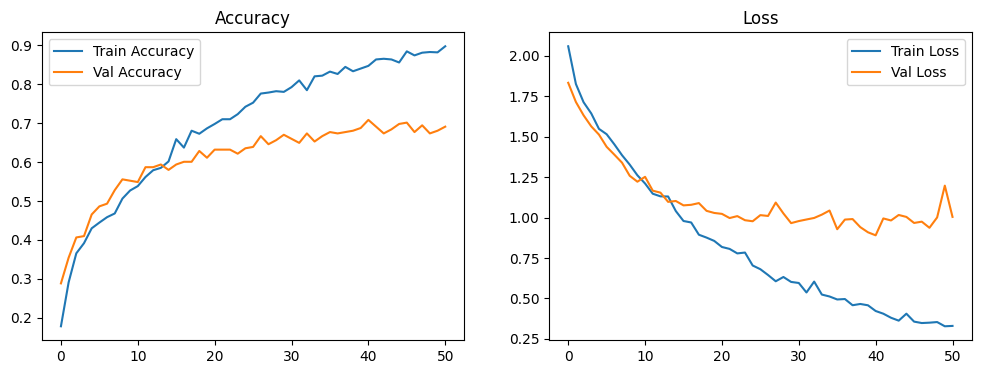

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
def predict_emotion(file_path):
    features = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
    if features is None:
        return
    features = scaler.transform(features.reshape(1, -1))  # SCALE HERE
    prediction = model.predict(features)
    predicted_label = le.inverse_transform([np.argmax(prediction)])
    print("Predicted Emotion:", predicted_label[0])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 03-01-02-01-01-02-19.wav to 03-01-02-01-01-02-19.wav


In [ ]:
with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

In [ ]:
for fn in uploaded.keys():
    predict_emotion(fn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Emotion: calm


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


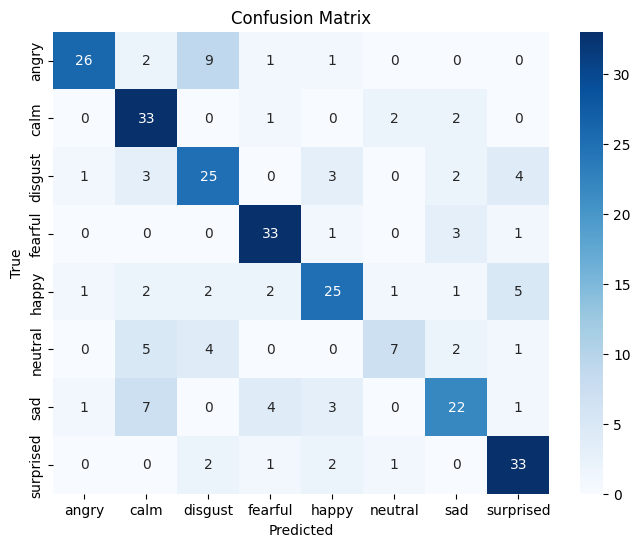

              precision    recall  f1-score   support

       angry       0.90      0.67      0.76        39
        calm       0.63      0.87      0.73        38
     disgust       0.60      0.66      0.62        38
     fearful       0.79      0.87      0.82        38
       happy       0.71      0.64      0.68        39
     neutral       0.64      0.37      0.47        19
         sad       0.69      0.58      0.63        38
   surprised       0.73      0.85      0.79        39

    accuracy                           0.71       288
   macro avg       0.71      0.69      0.69       288
weighted avg       0.72      0.71      0.70       288



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=le.classes_))